# In this notebook, we're going to take our json data tables and do some linear fittings

In [1]:
# helps with debugging in VSCode
%colors nocolor

In [2]:
import os
import sys
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import json
import seaborn as sns

try:
    from synoracle import ingredients
except ModuleNotFoundError:
    module_path = os.path.abspath(os.path.join('..'))
    if module_path not in sys.path:
        sys.path.append(module_path)
    from synoracle import ingredients

from tqdm.notebook import tqdm, trange

def li_iterate(li):
    l = iter(li)
    for _ in trange(len(li)):
        yield next(l)

In [3]:
with open("./broken_down_boms.json", 'r', encoding='utf-8') as f:
    rawdata = json.loads(f.read())

In [4]:
boms = pd.DataFrame(rawdata)

In [5]:
with open('./chemical_typing_crossreference.json', 'r', encoding='utf-8') as f:
    crossref = json.loads(f.read())

In [6]:
xref = pd.DataFrame(crossref)

xref.index = xref.index.astype(int)

In [7]:
boms_xrefed = pd.merge(boms, xref, left_on='level_0', right_index=True)
boms_xrefed['level_0'] = boms_xrefed['level_0'].astype(int)

In [8]:
boms_xrefed.head()

,level_0,step type,name,moles,synthesis_number,index,contains_imidazole,contains_nitrate,contains_sulfate,contains_acetate,contains_chloride,contains_oxide,contains_zinc,contains_cobalt,contains_acid,contains_base,contains_amphoteric,contains_surfactant,contains_solvent
0,962,add,[H2O],1.101671,0,0.0,False,False,False,False,False,False,False,False,False,False,False,False,True
24,962,add,[water],0.242368,4,0.0,False,False,False,False,False,False,False,False,False,False,False,False,True
26,962,remove,[water],0.000000,4,2.0,False,False,False,False,False,False,False,False,False,False,False,False,True
27,962,other,[water],0.000000,4,3.0,False,False,False,False,False,False,False,False,False,False,False,False,True
48,962,add,[water],0.550835,9,0.0,False,False,False,False,False,False,False,False,False,False,False,False,True


Text(0, 0.5, 'Frequency (# papers)')

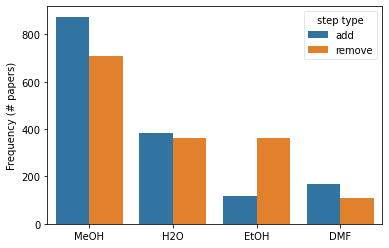

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt
solvent_table = boms_xrefed[boms_xrefed['contains_solvent']].groupby(
    ['level_0', 'step type'] 
).aggregate('count')

fig, ax = plt.subplots()
sns.set_context(rc = {'patch.linewidth': 0.6})

sns.barplot(
    data = solvent_table[(solvent_table['synthesis_number']>15) & (solvent_table.index.get_level_values('step type').isin(['add', 'remove']))].reset_index(),
    x = 'level_0',
    y = 'synthesis_number',
    hue='step type',
    order = [887, 962, 702, 6228],
    ax=ax,

    )

xticklabels = ['MeOH', 'H2O', 'EtOH', 'DMF']
ax.set_xticklabels(xticklabels, rotation=0)
ax.set_xlabel('')
ax.set_ylabel('Frequency (# papers)')

,step type,chemical,Count,Reaction stage
0,add,887,730,Addition
1,add,962,283,Addition
2,add,6228,117,Addition
3,add,887 962,56,Addition
4,add,702,53,Addition


c:\Users\d23895jm\Anaconda3\envs\SynOracle\lib\site-packages\ipykernel_launcher.py:55: UserWarning: FixedFormatter should only be used together with FixedLocator


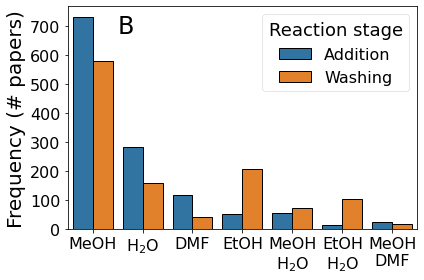

In [12]:
solvent_mixes = boms_xrefed[(boms_xrefed['contains_solvent'])].groupby(['synthesis_number', 'step type']).aggregate({'level_0':lambda x: ' '.join([str(x) for x in sorted(list(set(x)))])})


solvent_mixes_combined = pd.DataFrame(pd.concat({
    'add':solvent_mixes.xs('add', level=1).value_counts()[solvent_mixes.xs('add', level=1).value_counts()>10], 
    'remove': solvent_mixes.xs('remove', level=1).value_counts()[solvent_mixes.xs('remove', level=1).value_counts()>10]
    }), columns=['Count'])


solvent_mixes_combined.index = solvent_mixes_combined.index.rename('chemical', level=1).rename('step type', level=0)
solvent_mixes_combined = solvent_mixes_combined.reset_index()

solvent_mixes_combined['Reaction stage'] = solvent_mixes_combined['step type'].map({'add': 'Addition', 'remove': 'Washing'})

display(solvent_mixes_combined.head())
fig, ax = plt.subplots()

#sns.set_context(rc = {'patch.linewidth': 1, 'patch.edgecolor': 'k', 'alpha':1})

sns.barplot(
    data=solvent_mixes_combined,
    x='chemical',
    y='Count', 
    hue='Reaction stage', 
    ax=ax, 
    order=[
    "887", "962", "6228", "702",
    "887 962", "702 962",# "702 887",
    "887 6228",# "962 6228", "702 6228"
    ],
    edgecolor='k',
    linewidth=1,
    alpha=1
)


label_map = {
    "887": 'MeOH',
    "962": "H$_2$O",
    "6228": "DMF",
    "702": "EtOH",
    "887 962": "MeOH\nH$_2$O",
    "702 887": "MeOH\nEtOH",
    "887 6228": "MeOH\nDMF",
    "702 962": "EtOH\nH$_2$O",
    "962 6228": "DMF\nH$_2$O",
    "702 6228": "DMF\nEtOH"
}

ax.legend(fontsize=16, title = 'Reaction stage', title_fontsize=18)


xticklabels = [label_map[x.get_text()] for x in ax.get_xticklabels()]
ax.set_xticklabels(xticklabels, rotation=0, fontsize=16)
ax.set_yticklabels([int(x) for x in ax.get_yticks()], fontsize=16)
ax.set_ylabel('Frequency (# papers)', fontsize=20)
ax.annotate('B', (0.5, 675), fontsize=24)
ax.set_xlabel('')
#xticklabels

plt.tight_layout()
plt.savefig('Fig 4b.png', dpi=900)

c:\Users\d23895jm\Anaconda3\envs\SynOracle\lib\site-packages\ipykernel_launcher.py:49: UserWarning: FixedFormatter should only be used together with FixedLocator


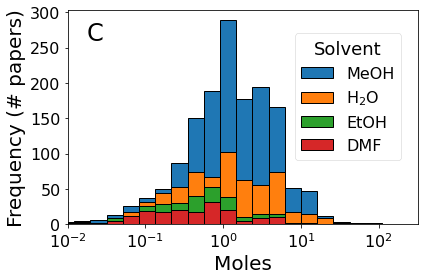

In [13]:
data = boms_xrefed[
    (boms_xrefed['contains_solvent']) &\
    (boms_xrefed['moles']>0) &\
    (boms_xrefed['level_0'].isin([887, 962, 702, 6228])) &\
    (boms_xrefed['step type'].isin(['add', 'remove']))
    ].rename({
    962: 'H2O',
    887: 'MeOH',
    702: 'EtOH',
    6228:'DMF',
    'level_0': 'Solvent'
    }, axis=1).replace({
    962: 'H2O',
    887: 'MeOH',
    702: 'EtOH',
    6228:'DMF',
    'level_0': 'Solvent'
    }).sort_values(by='Solvent', ascending=False)

data['logmoles'] = data['moles'].apply(np.log10)

fig, ax = plt.subplots()

sns.histplot(
    data = data,
    x = 'logmoles',
    hue='Solvent',
    multiple='stack',
    hue_order = ['MeOH', 'H2O', 'EtOH', 'DMF'],
    bins=30,
    ax=ax,
    edgecolor='k',
    linewidth=1,
    alpha=1
    )


legend = ax.get_legend()
handles = legend.legendHandles

legend.remove()
ax.legend(handles, ['MeOH', 'H$_2$O', 'EtOH', 'DMF'], fontsize=16, title = 'Solvent', title_fontsize=18, loc=(0.65,0.3))


ax.set_xlim([-2,2.5])

ax.set_xticks([-2,-1,0,1,2])
ax.set_xticklabels([ '$10^{-2}$', '$10^{-1}$', '$10^{0}$', '$10^{1}$', '$10^{2}$'], fontsize=16)
ax.set_yticklabels([int(x) for x in ax.get_yticks()], fontsize=16)

ax.set_ylabel('Frequency (# papers)', fontsize=20)
ax.set_xlabel('Moles', fontsize=20)
ax.annotate('C', (-1.75, 260), fontsize=24)

plt.tight_layout()
plt.savefig('Fig 4c.png', dpi=900)